<a href="https://colab.research.google.com/github/stratoskar/Path-Based-Traffic-Flow-Prediction/blob/main/Python_Code/6_Find_Best_Crossing_Time_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this section of the code, we train two discrete Machine Learning models with the purpose of forecasting path crossing time along every path we defined earlier.**

We remind you that the SPQ rules are fully described here: https://dl.acm.org/doi/abs/10.1145/2666310.2666413

In [68]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timestamp data types
from datetime import datetime, timedelta

In [69]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path with the data that we are interested in
PATH = '/content/drive/MyDrive/Paper/Timeseries/mean_time_to_cross_SPQ.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Prepare the dataset**

We use the necessary code to convert our time series dataframe into more usefull one.

In [70]:
# Read the time series dataset
crossing_times = pd.read_csv(PATH)

# This list contains the column names
columns = ["Taxi ID","Traj ID","Path","Length"]

# Generate the columns for the datasets
i =4
while(True):
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        columns.append(columns[i-1] + timedelta(seconds=1800))

    if (columns[i]>=pd.to_datetime('2008-06-10 09:30:04')):
        break

    i+=1

# Delete the last timestamp
columns.pop()

# Assign new column names to our dataframe
crossing_times.columns = columns

In [71]:
# Print first 2 rows of dataframe
crossing_times.head(2)

,Taxi ID,Traj ID,Path,Length,2008-05-17 10:00:04,2008-05-17 10:30:04,2008-05-17 11:00:04,2008-05-17 11:30:04,2008-05-17 12:00:04,2008-05-17 12:30:04,...,2008-06-10 04:30:04,2008-06-10 05:00:04,2008-06-10 05:30:04,2008-06-10 06:00:04,2008-06-10 06:30:04,2008-06-10 07:00:04,2008-06-10 07:30:04,2008-06-10 08:00:04,2008-06-10 08:30:04,2008-06-10 09:00:04
0,435,1026,"[619378869, 619378869, 254306573, 254306573, 2...",16,12.857143,12.2,8.75,14.5,13.0,5.5,...,0.0,0.0,0.0,11.0,7.5,13.5,16.0,5.0,14.0,0.0
1,104,1881,"[36331135, 410877299, 410877301, 410877301, 41...",11,0.000000,27.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# Reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = crossing_times.iloc[:,2:].columns
crossing_times = crossing_times.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Mean Crossing Time')
crossing_times['Time Column'] = pd.to_datetime(crossing_times['Time Column'])

# Sort rows by Path and Time
crossing_times.sort_values(by=['Path','Time Column'],inplace=True)

Convert 'Path' column to numerical

In [73]:
# Use label encoder
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
crossing_times['Path'] = label_encoder.fit_transform(crossing_times['Path'])

# Sort the data based in Path column
traffic_flow = crossing_times.sort_values(by=['Path','Time Column'])

In [74]:
# Print dataframe
crossing_times.head(5)

,Taxi ID,Traj ID,Path,Length,Time Column,Mean Crossing Time
286,271,870,0,4,2008-05-17 10:00:04,20.50
1286,271,870,0,4,2008-05-17 10:30:04,18.25
2286,271,870,0,4,2008-05-17 11:00:04,22.80
3286,271,870,0,4,2008-05-17 11:30:04,30.00
4286,271,870,0,4,2008-05-17 12:00:04,0.00


**Feature Creation From Time Information**

In this step we define some features based on time series timestamps.
- Day, day of week, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval to describe, in which interval of the day data refer to.

In [75]:
# Set the timestamps as the index of the dataframe
crossing_times.set_index('Time Column', inplace=True)

In [76]:
# Rename the index for easy understanding of the data
crossing_times = crossing_times.reset_index()
crossing_times.rename(columns={'index': 'Time Column'}, inplace=True)

In [77]:
### Extract timestamp information to different columns ###

crossing_times['hour'] = crossing_times['Time Column'].dt.hour
crossing_times['dayofweek'] = crossing_times['Time Column'].dt.dayofweek
crossing_times['day'] = crossing_times['Time Column'].dt.day
crossing_times['minute'] = crossing_times['Time Column'].dt.minute

### Circular Encoding for cyclic time features ###

crossing_times['hour_sin'] = np.sin(2 * np.pi * crossing_times['hour'] / 24)
crossing_times['hour_cos'] = np.cos(2 * np.pi * crossing_times['hour'] / 24)

crossing_times['day_of_week_sin'] = np.sin(2 * np.pi * crossing_times['dayofweek'] / 7)
crossing_times['day_of_week_cos'] = np.cos(2 * np.pi * crossing_times['dayofweek'] / 7)

crossing_times['day_sin'] = np.sin(2 * np.pi * crossing_times['day'] / 31)
crossing_times['day_cos'] = np.cos(2 * np.pi * crossing_times['day'] / 31)

crossing_times['minute_sin'] = np.sin(2 * np.pi * crossing_times['minute'] / 60)
crossing_times['minute_cos'] = np.cos(2 * np.pi * crossing_times['minute'] / 60)

In [78]:
# Define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

# Apply the custom function on the data to create the '3hour_interval' column
crossing_times['3hour_interval'] = crossing_times['hour'].apply(get_3hour_interval)

In [79]:
# Print crossing_times dataframe
crossing_times.head(5)

,Time Column,Taxi ID,Traj ID,Path,Length,Mean Crossing Time,hour,dayofweek,day,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
0,2008-05-17 10:00:04,271,870,0,4,20.50,10,5,17,0,5.000000e-01,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
1,2008-05-17 10:30:04,271,870,0,4,18.25,10,5,17,30,5.000000e-01,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,4
2,2008-05-17 11:00:04,271,870,0,4,22.80,11,5,17,0,2.588190e-01,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
3,2008-05-17 11:30:04,271,870,0,4,30.00,11,5,17,30,2.588190e-01,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,4
4,2008-05-17 12:00:04,271,870,0,4,0.00,12,5,17,0,1.224647e-16,-1.000000,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,5


#### **Make Visualizations**

Here, we are doing the following operations:
- View mean crossing_times (average number of crossing times using every path in the dataset) per timestep. In this way, we can understand patterns that traffic flow has.

- Compute average crossing times per 3-hour interval, to understand in which time of each day crossing times are on its peak.

- Find correlations among columns in the dataset.

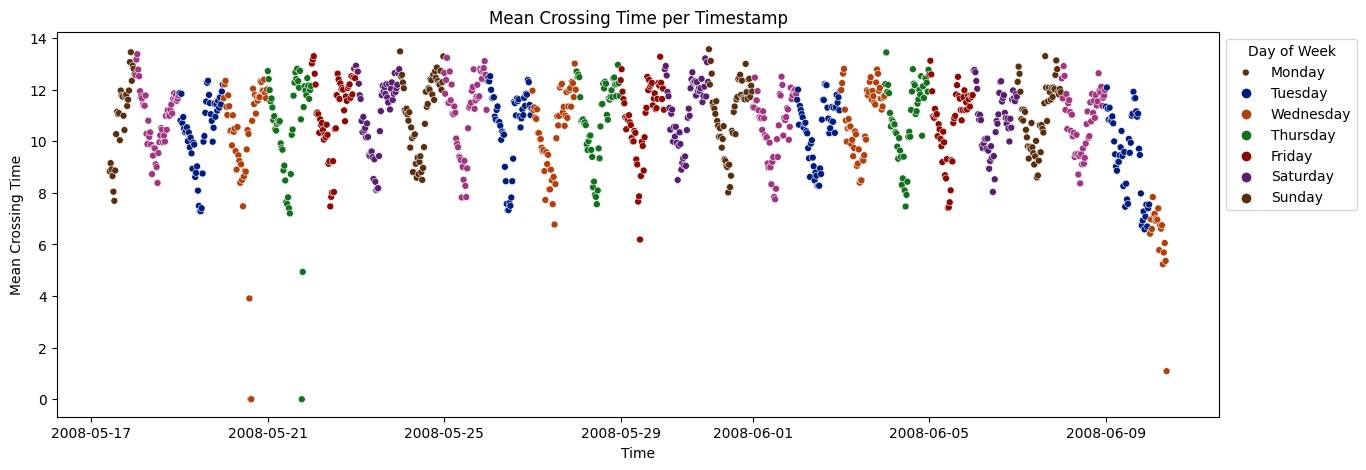

In [80]:
# Group by timestamp and calculate the mean of the crossing times
grouped_df = crossing_times['Mean Crossing Time'].groupby(crossing_times['Time Column']).mean()

# Add results to dataframe
grouped_df = pd.DataFrame(grouped_df,index=grouped_df.index)

# Add additional time information in the dataset
grouped_df['hour'] = grouped_df.index.hour
grouped_df['3hour_interval'] = grouped_df['hour'].apply(get_3hour_interval)
grouped_df['dayofweek'] = grouped_df.index.dayofweek

# Create a custom dark color palette
dark_palette = sns.color_palette('dark')

# Create a plot to view the results
plt.figure(figsize=(15,5))
sns.scatterplot(grouped_df,x=grouped_df.index,y='Mean Crossing Time',hue='dayofweek',marker='o', palette=dark_palette, s=25)
plt.xlabel('Time')
plt.ylabel('Mean Crossing Time')
plt.title('Mean Crossing Time per Timestamp')

# Set the legend title
plt.legend(title='Day of Week', labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],bbox_to_anchor=(1, 1), loc='upper left')

# Show graph
plt.show()

This plot above shows us the mean crossing times per timestamp (considering every path).

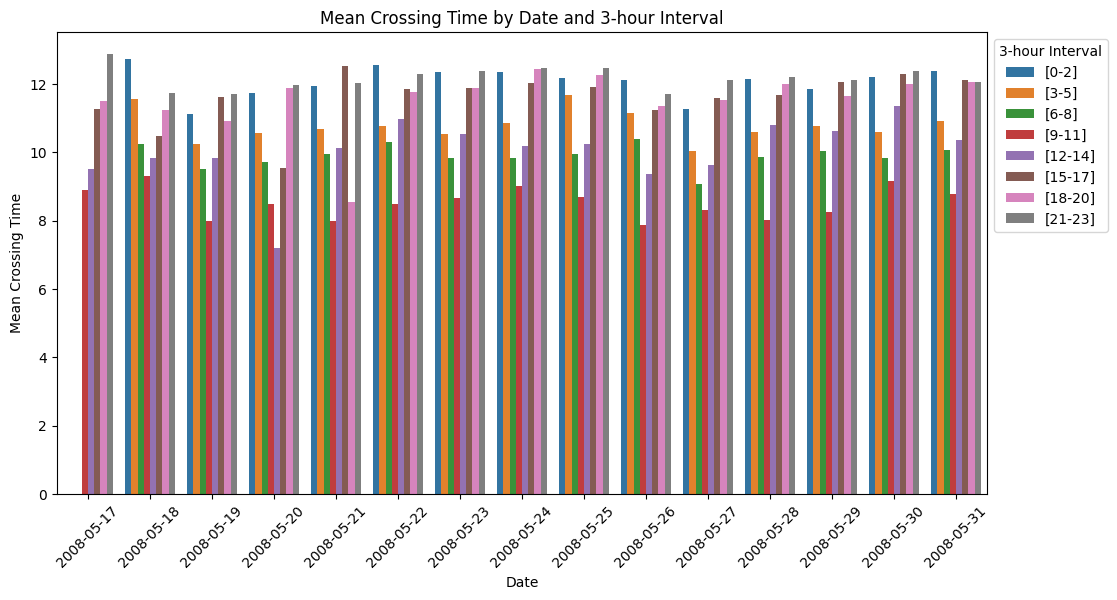

In [81]:
# Filter the original 'crossing_times' dataframe to include only rows before '2008-06-01'
df = crossing_times[crossing_times['Time Column'] < '2008-06-01']

# Extract the date from the 'Time Column' and create a new column 'Date'
df['Date'] = df['Time Column'].dt.date

# Group the dataframe by 'Date' and '3hour_interval' and calculate the mean of the 'Mean Crossing Time' for each group
new_df = df.groupby(['Date', '3hour_interval'])['Mean Crossing Time'].mean().reset_index()

# Map the '3hour_interval' values to custom labels using a dictionary
interval_labels = {1: '[0-2]', 2: '[3-5]', 3: '[6-8]', 4: '[9-11]', 5: '[12-14]', 6: '[15-17]', 7: '[18-20]', 8: '[21-23]'}
new_df['3hour_interval_label'] = new_df['3hour_interval'].map(interval_labels)

# Create a Seaborn bar plot with stacked bars, specifying the order of the legend
plt.figure(figsize=(12, 6))
sns.barplot(x='Date', y='Mean Crossing Time', hue='3hour_interval_label', data=new_df, hue_order=interval_labels.values())

# Add title and axis labels
plt.title('Mean Crossing Time by Date and 3-hour Interval')
plt.xlabel('Date')
plt.ylabel('Mean Crossing Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend with a specified title and position
plt.legend(title='3-hour Interval', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()

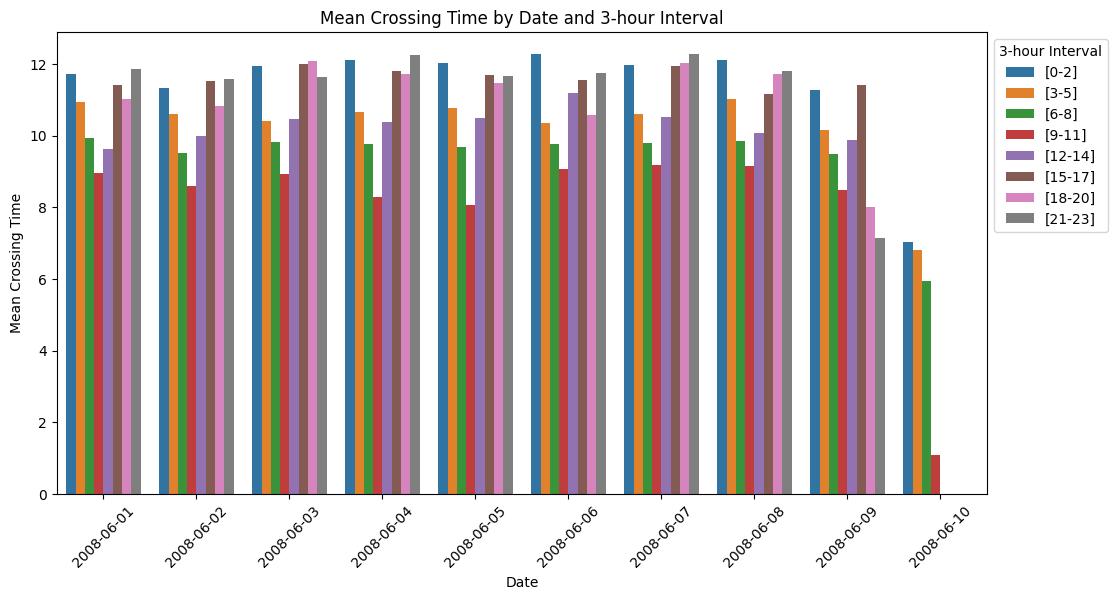

In [82]:
# Filter the original 'crossing_times' dataframe to include only rows after '2008-06-01'
df = crossing_times[crossing_times['Time Column'] >= '2008-06-01']

# Extract the date from the 'Time Column' and create a new column 'Date'
df['Date'] = df['Time Column'].dt.date

# Group the dataframe by 'Date' and '3hour_interval' and calculate the mean of the 'Mean Crossing Time' for each group
new_df = df.groupby(['Date', '3hour_interval'])['Mean Crossing Time'].mean().reset_index()

# Map the '3hour_interval' values to custom labels using a dictionary
interval_labels = {1: '[0-2]', 2: '[3-5]', 3: '[6-8]', 4: '[9-11]', 5: '[12-14]', 6: '[15-17]', 7: '[18-20]', 8: '[21-23]'}
new_df['3hour_interval_label'] = new_df['3hour_interval'].map(interval_labels)

# Create a Seaborn bar plot with stacked bars, specifying the order of the legend
plt.figure(figsize=(12, 6))
sns.barplot(x='Date', y='Mean Crossing Time', hue='3hour_interval_label', data=new_df, hue_order=interval_labels.values())

# Add title and axis labels
plt.title('Mean Crossing Time by Date and 3-hour Interval')
plt.xlabel('Date')
plt.ylabel('Mean Crossing Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend with a specified title and position
plt.legend(title='3-hour Interval', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()

The results of the above two plots are expected, since traffic flow levels are lower due noon hours.

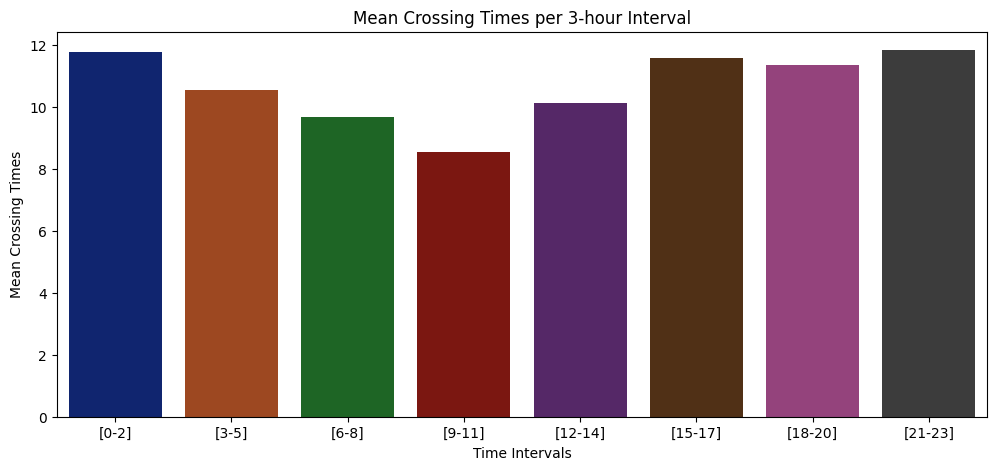

In [83]:
# Group by 3hour_interval and calculate the mean of the crossing times
grouped_df = crossing_times['Mean Crossing Time'].groupby(crossing_times['3hour_interval']).mean()

# Add results to dataframe
grouped_df = pd.DataFrame(grouped_df,index=grouped_df.index)

# Define the intervals (use strings for easy understanding)
intervals = ['[0-2]','[3-5]','[6-8]','[9-11]','[12-14]','[15-17]','[18-20]','[21-23]']
grouped_df['Hour Interval'] = intervals

# Create a custom dark color palette
dark_palette = sns.color_palette('dark')

# Create a plot to view the results
plt.figure(figsize=(12,5))
sns.barplot(grouped_df, x='Hour Interval', y='Mean Crossing Time', palette=dark_palette)
plt.xlabel('Time Intervals')
plt.ylabel('Mean Crossing Times')
plt.title('Mean Crossing Times per 3-hour Interval')

# Show graph
plt.show()

This plot suggests that during noon hours, mean crossing times are at lower levels, instead of morning and evening hours. This sounds correct, as traffic flow is lower during noon hours and higher during the rest of the day.

Text(0.5, 1.0, 'Mean Crossing Time per Day of Week')

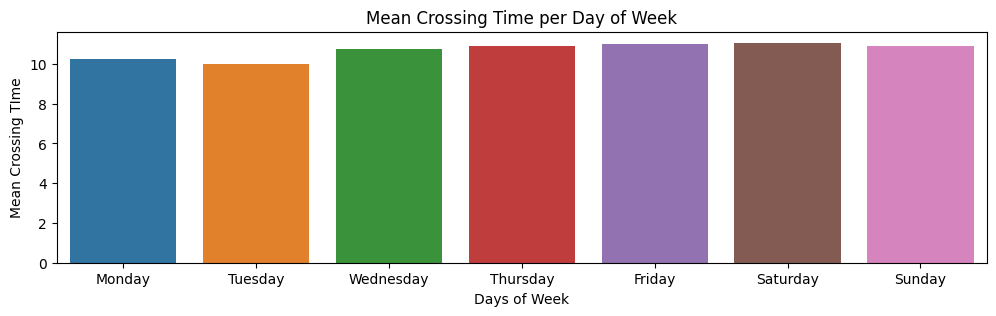

In [84]:
# Group by dayofweek and calculate the mean of the traffic flow
grouped_df = pd.DataFrame(crossing_times['Mean Crossing Time'].groupby(crossing_times['dayofweek']).mean())
grouped_df['Days'] = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Create a plot to view the results
plt.figure(figsize=(12,3))
sns.barplot(grouped_df,x='Days',y='Mean Crossing Time')
plt.xlabel('Days of Week')
plt.ylabel('Mean Crossing TIme')
plt.title('Mean Crossing Time per Day of Week')

The graph above shows that mean crossing times per day follow a uniform distribution.

Text(0, 0.5, 'Mean Crossing TIme')

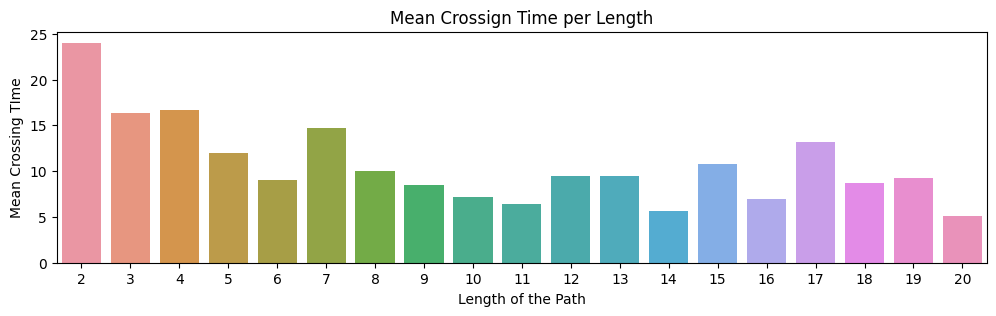

In [85]:
# Create a DataFrame by grouping 'Traffic Flow' by 'Length' and calculating the mean
group_by_length = pd.DataFrame(crossing_times['Mean Crossing Time'].groupby(crossing_times['Length']).mean())

# Create a plot to view the results
plt.figure(figsize=(12,3))
sns.barplot(group_by_length,x=group_by_length.index,y='Mean Crossing Time')
plt.xlabel('Length of the Path')
plt.title('Mean Crossign Time per Length')
plt.ylabel('Mean Crossing TIme')

The plot above shares the average crossing time of a path that has a specific length (in seconds).

<Axes: >

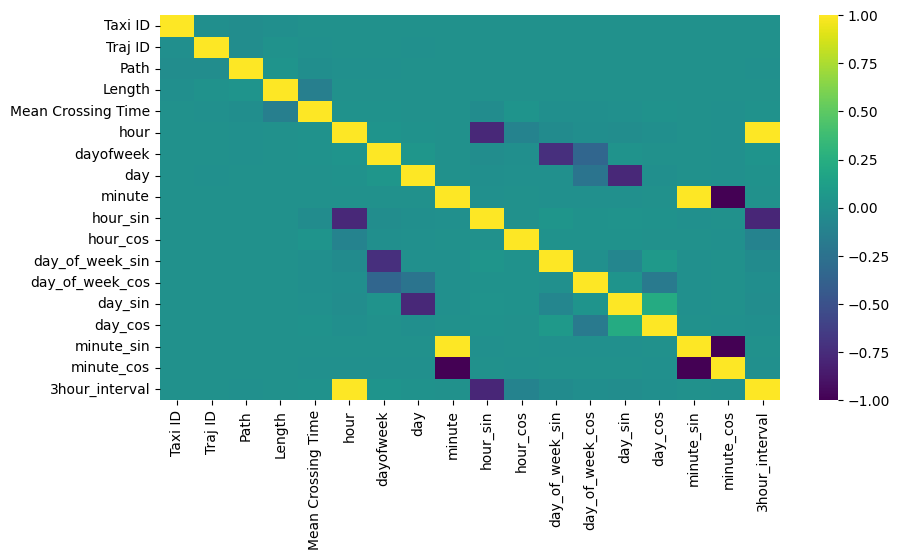

In [86]:
# Find highly correlated data in the crossing_times dataset
plt.figure(figsize=(10,5))
sns.heatmap(crossing_times.corr(), annot=False, cmap='viridis')

Based on the heatmap above, we can see that there is a strong correlation between the:

*  minute_cos and minute attributes
*  hour_sin and 3hour_interval
*  hour and 3hour_interval
*  hour_sin and hour
*  dayofweek and day_of_week_sin
*  dayofweek and day_of_week_cos
*  day and day_sin
*  minute and minute_sin
*  minute_cos and minute_sin

So, due to the fact that these features are highly correlated, the information they share is almost the same. So, we can drop the following features, to create a simpler model: minute, day, 3hour_interval, dayofweek and hour.








In [87]:
# Delete high correlated columns
crossing_times.drop(['minute', 'day', '3hour_interval', 'dayofweek', 'hour'],axis=1,inplace=True)

#### **Tune XGBoost model**


In [88]:
print(f"Earlier timestamp in traffic_flow dataframe is: {crossing_times['Time Column'].min()}")
print(f"Latest timestamp in traffic_flow dataframe is: {crossing_times['Time Column'].max()}")

Earlier timestamp in traffic_flow dataframe is: 2008-05-17 10:00:04
Latest timestamp in traffic_flow dataframe is: 2008-06-10 09:00:04


**Train and Test split of the dataset**

In this step, we split the data into two datasets, train and test.
- Train dataset contains all the data for each path till 08-06-2008 inclusive.
- The rest of the data (the most resent ones) are in the test dataset

In [89]:
# Sort the time series data
crossing_times.sort_values(by=['Path','Time Column'], inplace=True)

In [90]:
# Define train data
train= crossing_times.loc[crossing_times['Time Column'] < '2008-06-09']

# Define test data
test = crossing_times.loc[crossing_times['Time Column'] >= '2008-06-09']

# Print the results
print("Train set shape: ",train.shape)
print("Test set shape: ",test.shape)

Train set shape:  (1084000, 14)
Test set shape:  (67000, 14)


**Find the best lookback timesteps for our XGBoost model**

In this step, we define the optimum lookback timestep number for our sliding window. This optimum number will be used by the model for forecasting.

In [91]:
# Find best lookback timesteps to perform analysis on traffic_flow dataset. Save those scores in a separate dataframe
lookback_scores = pd.DataFrame(columns=['#Timesteps','XGBoost Score'])
lookback_scores['#Timesteps'] = 0
lookback_scores['XGBoost Score'] = 0

**Create function that converts the data into a supervised problem**

Consider for each path n_in timesteps of observations in the past, in order to predict the n_out timesteps in the future.

In [92]:
# Create function for generating (X, y) pairs
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Record %d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Record %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Record %d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

def generate_X_y_pairs(data,n_in=1,n_out=1):
    """
    Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
    Then, concatenate the rest of the culumns.
    """
    new_data = pd.DataFrame()
    for item in data['Path'].unique():

        # call function only for traffic flow columns
        supervised = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Mean Crossing Time']), n_in, n_out)

        # the rest of the columns are concatenated as they were
        supervised = pd.concat([supervised, crossing_times[crossing_times['Path'] == item]], axis=1)

        new_data = pd.concat([new_data,supervised])

    new_data.dropna(inplace=True)
    return new_data

Create a loop. In each loop, we are doing the following:
- 0. Convert train and test sets into supervised problems with lookback timesteps.
- 1. Define features and labels.
- 2. Train the XGboost model with defult parameters.
- 3. Predict on the test set.
- 4. Save RMSE in a dataframe.

In [93]:
# Import libraries to use XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [94]:
for lookback in [2,3,4,5,6]: # Use different lookback sizes

    # Convert train and test data to supervised
    train_s = generate_X_y_pairs(train,lookback)
    test_s = generate_X_y_pairs(test,lookback)

    print("Lookback = "+str(lookback)+" - To supervised: Completed!")

    # Add rolling mean information
    train_s['rolling_mean'] = 0
    test_s['rolling_mean'] = 0

    train_s['rolling_mean'] = train_s.iloc[:,0:lookback].mean(axis=1)
    test_s['rolling_mean'] = test_s.iloc[:,0:lookback].mean(axis=1)

    # Define features
    features_s = train_s.drop(['Mean Crossing Time', 'Record 1(t)', 'Time Column'],axis=1).columns

    # Define label
    labels_s = ['Record 1(t)']

    # Create X_train and y_train datasets
    X_train_s = train_s[features_s]
    y_train_s = train_s[labels_s]

    # Create X_test and y_test datasets
    X_test_s = test_s[features_s]
    y_test_s = test_s[labels_s]

    print("Lookback = "+str(lookback)+" - Train and Test sets: Completed!")

    # Define XGBoost regression model
    reg = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100,early_stopping_rounds = 5)

    # Train the XGBoost model with feature weights (use validation set on test data)
    reg.fit(X_train_s, y_train_s, eval_set=[(X_train_s, y_train_s), (X_test_s,y_test_s)],verbose=False)

    print("Lookback = "+str(lookback)+" - Trainning: Completed!")

    # Make predictions
    y_pred_s = reg.predict(X_test_s)

    # Calculate RMSE score
    rmse = mean_squared_error(y_test_s, y_pred_s, squared=False)

    # Create a new row as a dictionary
    new_row = {'#Timesteps': lookback, 'XGBoost Score': rmse}

    # Append the new row to the DataFrame
    lookback_scores = lookback_scores.append(new_row, ignore_index=True)

    print("Lookback = "+str(lookback)+" - Saved Results: Completed!")

Lookback = 2 - To supervised: Completed!
Lookback = 2 - Train and Test sets: Completed!
Lookback = 2 - Trainning: Completed!
Lookback = 2 - Saved Results: Completed!
Lookback = 3 - To supervised: Completed!
Lookback = 3 - Train and Test sets: Completed!
Lookback = 3 - Trainning: Completed!
Lookback = 3 - Saved Results: Completed!
Lookback = 4 - To supervised: Completed!
Lookback = 4 - Train and Test sets: Completed!
Lookback = 4 - Trainning: Completed!
Lookback = 4 - Saved Results: Completed!
Lookback = 5 - To supervised: Completed!
Lookback = 5 - Train and Test sets: Completed!
Lookback = 5 - Trainning: Completed!
Lookback = 5 - Saved Results: Completed!
Lookback = 6 - To supervised: Completed!
Lookback = 6 - Train and Test sets: Completed!
Lookback = 6 - Trainning: Completed!
Lookback = 6 - Saved Results: Completed!


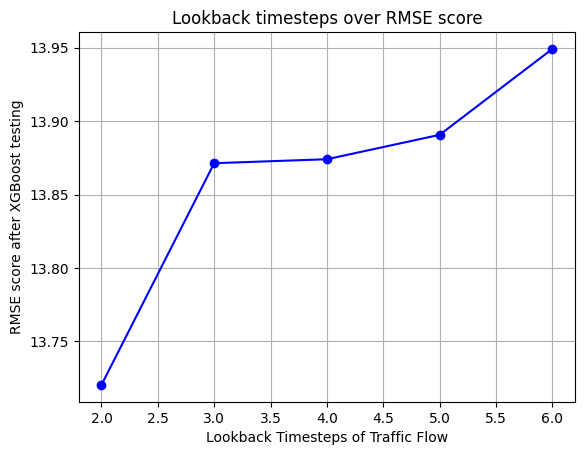

In [95]:
# Use a plot to show the results
plt.plot(lookback_scores['#Timesteps'], lookback_scores['XGBoost Score'], linestyle='-', marker='o', color='b')

# Set plot title and axis labels
plt.title('Lookback timesteps over RMSE score')
plt.xlabel('Lookback Timesteps of Traffic Flow')
plt.ylabel('RMSE score after XGBoost testing')

# Add gridlines
plt.grid(True)

# Show the plot
plt.show()

In [96]:
# Find the timesteps corresponding to the minimum RMSE score
optimum_lookback = int(lookback_scores['#Timesteps'].loc[lookback_scores['XGBoost Score'].idxmin()])

In [97]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

**Extract features about trend of time series**

In this step we define the rolling mean and rolling variance of a window. Since we are trying to forecast the last value of each window, only the first optimum_lookback values in the window are used to compute rolling features. The last value (that we are trying to forecast) is not included.

In [98]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:optimum_lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

**Define labels and features**

- Features will help the XGboost algorithm to predict the output value (the label). We will use all the traffic flow information at previous timesteps (t-n,t-n+1...,t-2,t-1), as well as the rest of the features (time and trend information) as features.

- Label will be out target value, the Mean Crossing Time at timestep t.

In [99]:
# Define features
features = train.drop(['Time Column','Record 1(t)','Mean Crossing Time'],axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

In [100]:
# Show shape information about X and y training and testing sets
print("Shape of X_train is: ",X_train.shape)
print("Shape of y_train is: ",y_train.shape)
print("Shape of X_test is: ",X_test.shape)
print("Shape of y_test is: ",y_test.shape)

Shape of X_train is:  (1082000, 16)
Shape of y_train is:  (1082000, 1)
Shape of X_test is:  (65000, 16)
Shape of y_test is:  (65000, 1)


**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [101]:
# Import Grid Search library
from sklearn.model_selection import GridSearchCV

In [102]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1,0.01],
    "max_depth": [3,9],
    "gamma":[0.2]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        verbose=1,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[0]	validation_0-rmse:20.46582	validation_1-rmse:19.27249
[1]	validation_0-rmse:19.29719	validation_1-rmse:18.40043
[2]	validation_0-rmse:18.28509	validation_1-rmse:17.65915
[3]	validation_0-rmse:17.39797	validation_1-rmse:17.02144
[4]	validation_0-rmse:16.70992	validation_1-rmse:16.53637
[5]	validation_0-rmse:16.14924	validation_1-rmse:16.15526
[6]	validation_0-rmse:15.60069	validation_1-rmse:15.79172
[7]	validation_0-rmse:15.14255	validation_1-rmse:15.49169
[8]	validation_0-rmse:14.73476	validation_1-rmse:15.23482
[9]	validation_0-rmse:14.44120	validation_1-rmse:15.04955
[10]	validation_0-rmse:14.19389	validation_1-rmse:14.90296
[11]	validation_0-rmse:13.94650	validation_1-rmse:14.76142
[12]	validation_0-rmse:13.74320	validation_1-rmse:14.64636
[13]	validation_0-rmse:13.59993	validation_1-rmse:14.56787
[14]	validation_0-rmse:13.45171	validation_1-rmse:14.48401
[15]	validation_0-rmse:13.35746	validation_1-rmse:14.43631
[16]	v

#### **Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [103]:
# Create dataframe to save actual values and model predictions
total_predictions = pd.DataFrame(index=pd.to_datetime(test['Time Column']))
total_predictions['Actual'] = y_test['Record 1(t)'].values
total_predictions['Path'] = X_test['Path'].values

In [104]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 500,
    gamma = xgb_grid.best_params_['gamma'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=True)

[0]	validation_0-rmse:20.43514	validation_1-rmse:19.32064
[1]	validation_0-rmse:19.24868	validation_1-rmse:18.42653
[2]	validation_0-rmse:18.22256	validation_1-rmse:17.67141
[3]	validation_0-rmse:17.34037	validation_1-rmse:17.03507
[4]	validation_0-rmse:16.58864	validation_1-rmse:16.50623
[5]	validation_0-rmse:15.94855	validation_1-rmse:16.06369
[6]	validation_0-rmse:15.40150	validation_1-rmse:15.69888
[7]	validation_0-rmse:14.94467	validation_1-rmse:15.40000
[8]	validation_0-rmse:14.55737	validation_1-rmse:15.15653
[9]	validation_0-rmse:14.23201	validation_1-rmse:14.95589
[10]	validation_0-rmse:13.96362	validation_1-rmse:14.79505
[11]	validation_0-rmse:13.74093	validation_1-rmse:14.66955
[12]	validation_0-rmse:13.55396	validation_1-rmse:14.56988
[13]	validation_0-rmse:13.39774	validation_1-rmse:14.48357
[14]	validation_0-rmse:13.26750	validation_1-rmse:14.41579
[15]	validation_0-rmse:13.15188	validation_1-rmse:14.35400
[16]	validation_0-rmse:13.06261	validation_1-rmse:14.31047
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Figure size 1500x500 with 0 Axes>

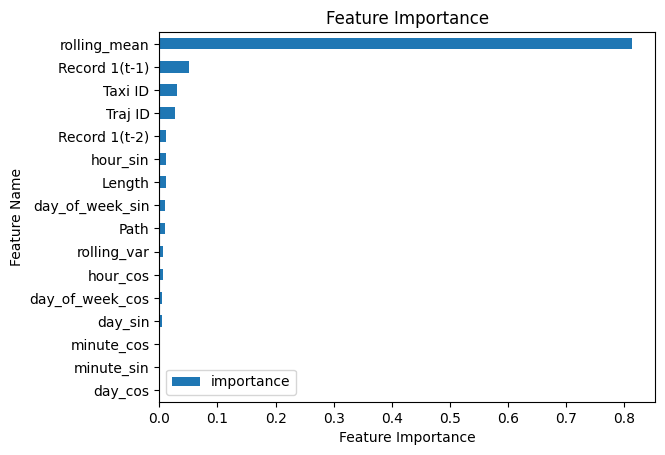

In [105]:
# Show how much each of the features was used in our regression analysis
plt.figure(figsize=(15,5))
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

Plot train and validation errors of XGBoost model in the same graph

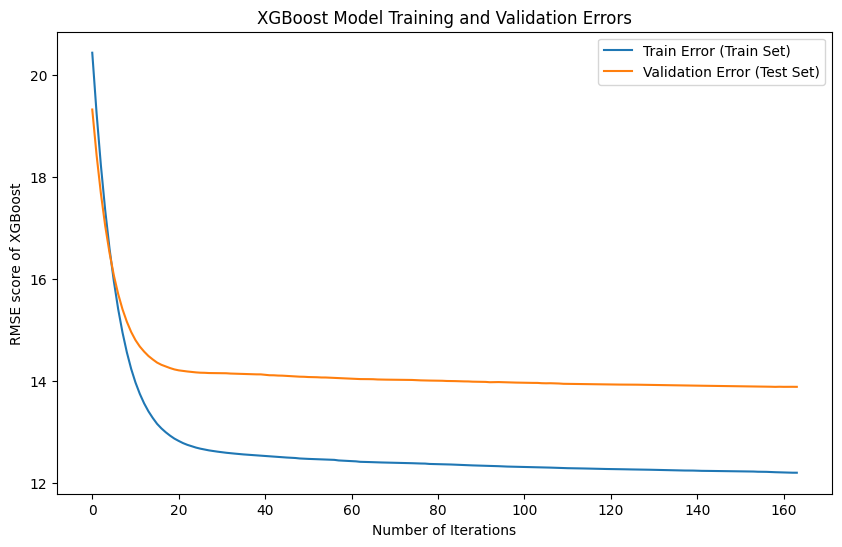

In [106]:
# Acquire the values of train and validation errors
results = reg.evals_result()
train_errors = results['validation_0']['rmse']
validation_errors = results['validation_1']['rmse']

# Plot the validation and training errors
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train Error (Train Set)')
plt.plot(validation_errors, label='Validation Error (Test Set)')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE score of XGBoost')
plt.title('XGBoost Model Training and Validation Errors')
plt.legend()
plt.show()

Make predictions on the test set

In [107]:
y_pred_xgboost = reg.predict(X_test)

In [108]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  5.411536093592882
RMSE score: 13.87788870081403


Show example of how well the model learned the trainning data.


Use a random path to visualize the results

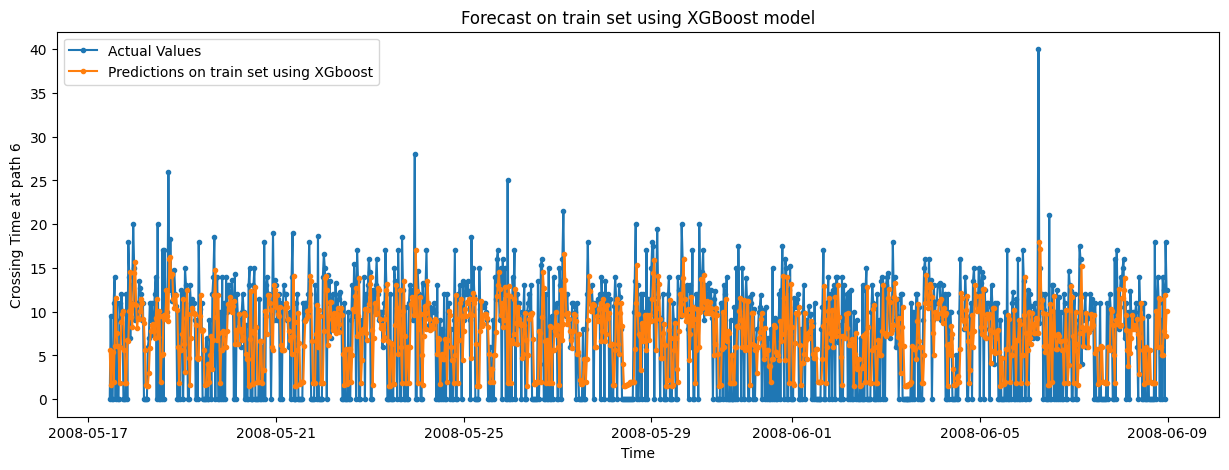

In [109]:
# Predict on the trainning set
y_pred_train = reg.predict(X_train)

# Add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Record 1(t)'].values)
train_predictions.insert(1,'Train Predicted',y_pred_train)
train_predictions.insert(2,'Path',X_train['Path'].values)

# Plot an example of the train-predictions at path 6 of the datase
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==6]['Train Actual'],".-",label='Actual Values')
plt.plot(train_predictions[train_predictions['Path']==6]['Train Predicted'],".-",label='Predictions on train set using XGboost')
plt.xlabel('Time')
plt.ylabel('Crossing Time at path 6')
plt.title('Forecast on train set using XGBoost model')
plt.legend()
plt.show()

#### **Train LSTM for time series forecasting**
This is the second model that we will train on the same dataset. We use the optimum lookback score that we computed above, before training the XGboost algorithm. This ensures that the LSTM model will be trained on the same data as the XGboost algorithm.

In [110]:
# Import library for data scaling
from sklearn.preprocessing import MinMaxScaler

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [111]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [112]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [113]:
# Create 3D test set FOR LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In [114]:
# Print shapes of the created sets
trainX.shape, trainY.shape, testX.shape, testY.shape

((1082000, 1, 16), (1082000, 1, 1), (65000, 1, 16), (65000, 1, 1))

Use the LSTM model for forecasting

In [115]:
# Import libraries and define the LSTM structure
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [116]:
# Define LSTM model
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

In [117]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [118]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          verbose=1,
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 10s 29ms/step - loss: 2.5222e-04 - val_loss: 1.5720e-04
Epoch 2/50
100/100 [==============================] - 2s 20ms/step - loss: 2.5052e-04 - val_loss: 1.5699e-04
Epoch 3/50
100/100 [==============================] - 2s 21ms/step - loss: 2.5054e-04 - val_loss: 1.5638e-04
Epoch 4/50
100/100 [==============================] - 2s 24ms/step - loss: 2.5052e-04 - val_loss: 1.5616e-04
Epoch 5/50
100/100 [==============================] - 2s 24ms/step - loss: 2.5061e-04 - val_loss: 1.5502e-04
Epoch 6/50
100/100 [==============================] - 2s 20ms/step - loss: 2.5055e-04 - val_loss: 1.6034e-04
Epoch 7/50
100/100 [==============================] - 2s 20ms/step - loss: 2.5067e-04 - val_loss: 1.5541e-04
Epoch 8/50
100/100 [==============================] - 2s 20ms/step - loss: 2.5052e-04 - val_loss: 1.5585e-04
Epoch 9/50
100/100 [==============================] - 2s 19ms/step - loss: 2.5061e-04 - val_loss: 1.5703e-04
Epoch 10/50
100/10

In [119]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

2032/2032 [==============================] - 9s 4ms/step - loss: 1.5338e-04
Test Loss: 0.00015338105731643736


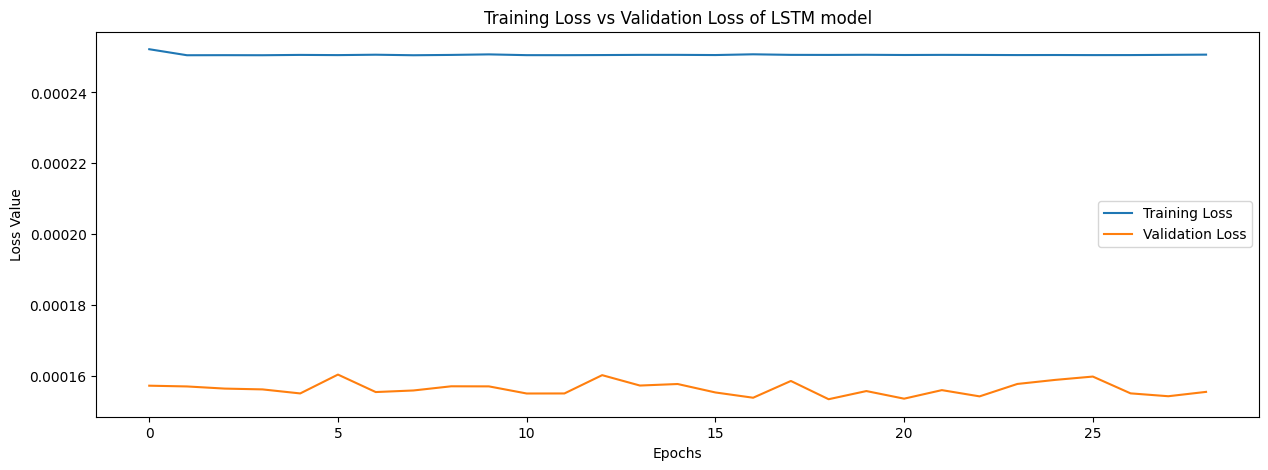

In [120]:
### PLOT TRAIN VS. VALIDATION LOSS OF LSTM MODEL ###

# Extract training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plt.figure(figsize=(15,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Training Loss vs Validation Loss of LSTM model')
plt.legend()

# Show the plot
plt.show()

In [121]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

2032/2032 [==============================] - 10s 5ms/step


Evaluate the LSTM model

In [122]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  11.720781338831454
RMSE LSTM score: 20.509101965208185


33813/33813 [==============================] - 145s 4ms/step


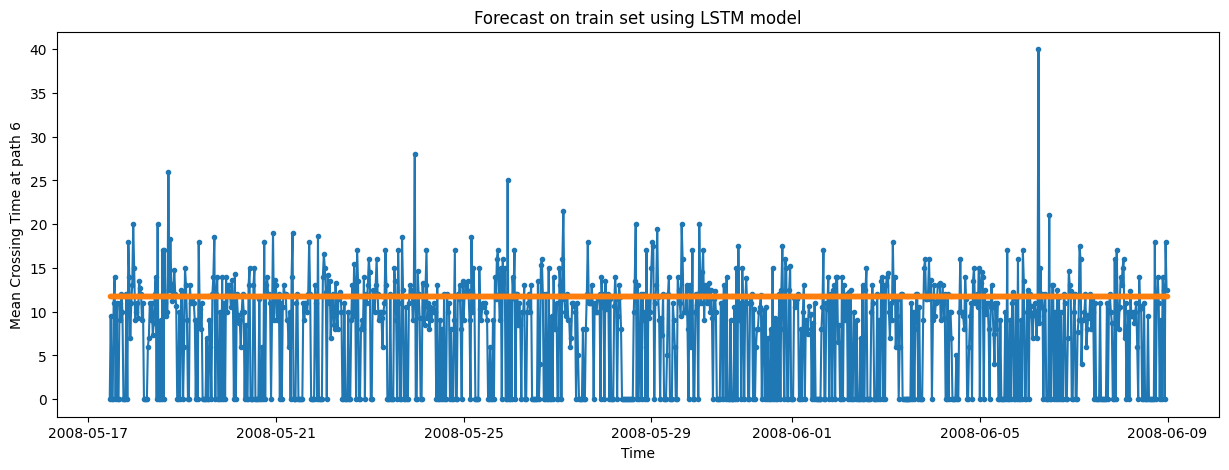

In [123]:
# Predict on the trainning set
y_pred_train_LSTM = model.predict(trainX)

# Add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Record 1(t)'].values)
train_predictions.insert(1,'Train Predicted',scaler.inverse_transform(y_pred_train_LSTM.reshape(-1,1)))
train_predictions.insert(2,'Path',X_train['Path'].values)

# Plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==6][['Train Actual','Train Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Mean Crossing Time at path 6')
plt.title('Forecast on train set using LSTM model')
plt.show()

#### Show results of two models

In [124]:
# Store predictions of XGBoost model to a dataframe
total_predictions['Predicted XGBoost'] = y_pred_xgboost

In [125]:
# Store predictions of LSTM model to a dataframe
total_predictions['Predicted LSTM'] = y_pred_lstm.reshape(-1,1)

In [126]:
# Print dataframe with predictions
total_predictions

,Actual,Path,Predicted XGBoost,Predicted LSTM
Time Column,,,,
2008-06-09 01:00:04,25.833333,0,25.894814,11.796635
2008-06-09 01:30:04,22.250000,0,24.496321,11.796635
2008-06-09 02:00:04,24.350000,0,22.287714,11.796635
2008-06-09 02:30:04,25.857143,0,22.777592,11.796635
2008-06-09 03:00:04,27.133333,0,24.308214,11.796635
...,...,...,...,...
2008-06-10 07:00:04,0.000000,999,3.278971,11.796635
2008-06-10 07:30:04,0.000000,999,3.278971,11.796635
2008-06-10 08:00:04,0.000000,999,3.278971,11.796635


[]

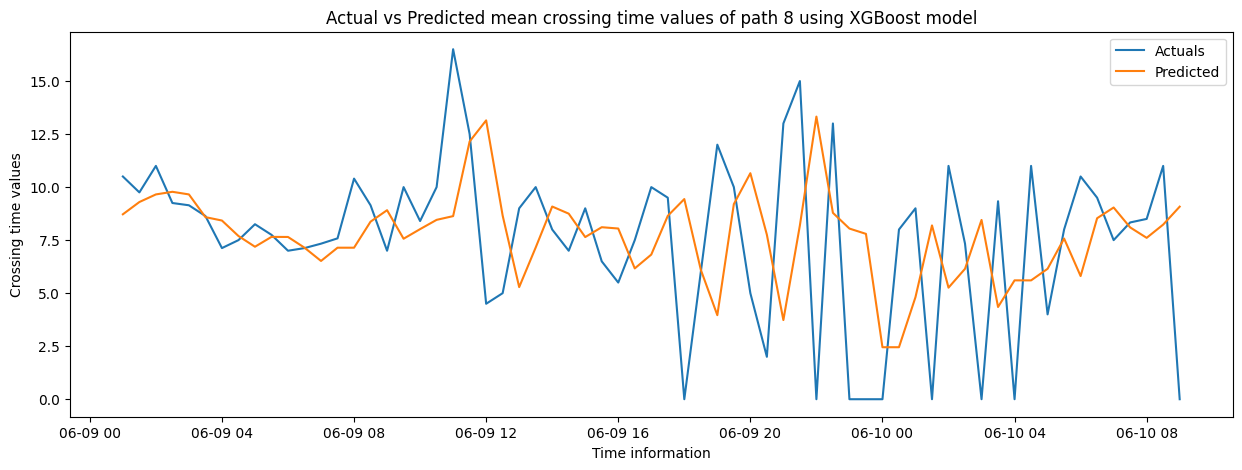

In [127]:
# Plot predictions from LSTM model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==8]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==8]['Predicted XGBoost'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Crossing time values')
plt.title('Actual vs Predicted mean crossing time values of path 8 using XGBoost model')
plt.legend()
plt.plot()

[]

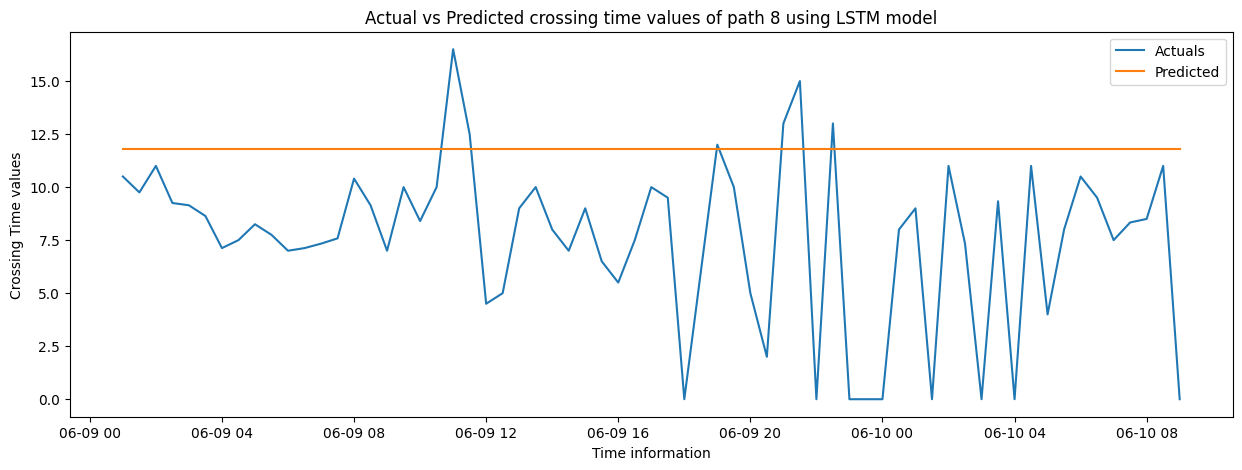

In [128]:
# Plot predictions from LSTM model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==8]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==8]['Predicted LSTM'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Crossing Time values')
plt.title('Actual vs Predicted crossing time values of path 8 using LSTM model')
plt.legend()
plt.plot()

[]

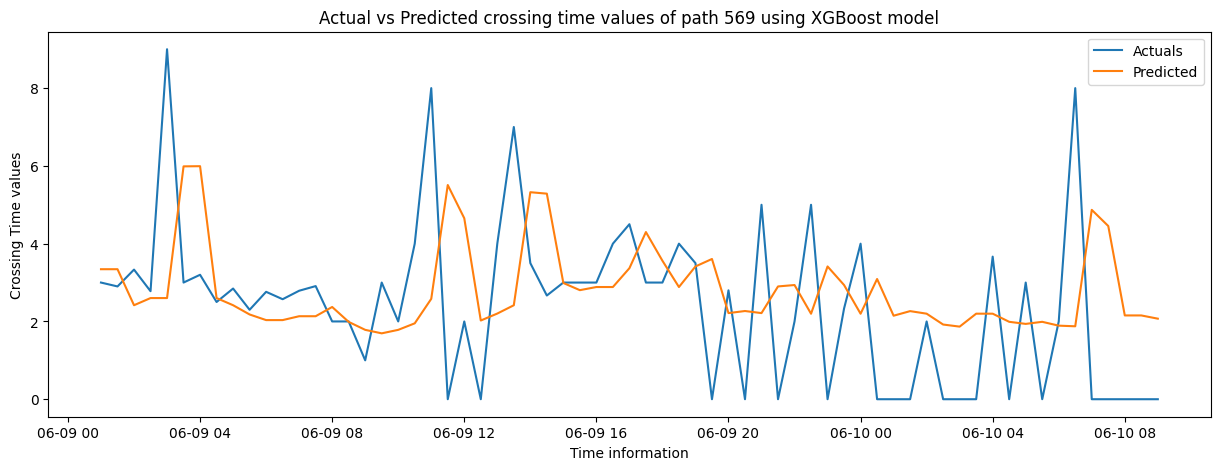

In [129]:
# Plot predictions from LSTM model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==569]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==569]['Predicted XGBoost'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Crossing Time values')
plt.title('Actual vs Predicted crossing time values of path 569 using XGBoost model')
plt.legend()
plt.plot()

[]

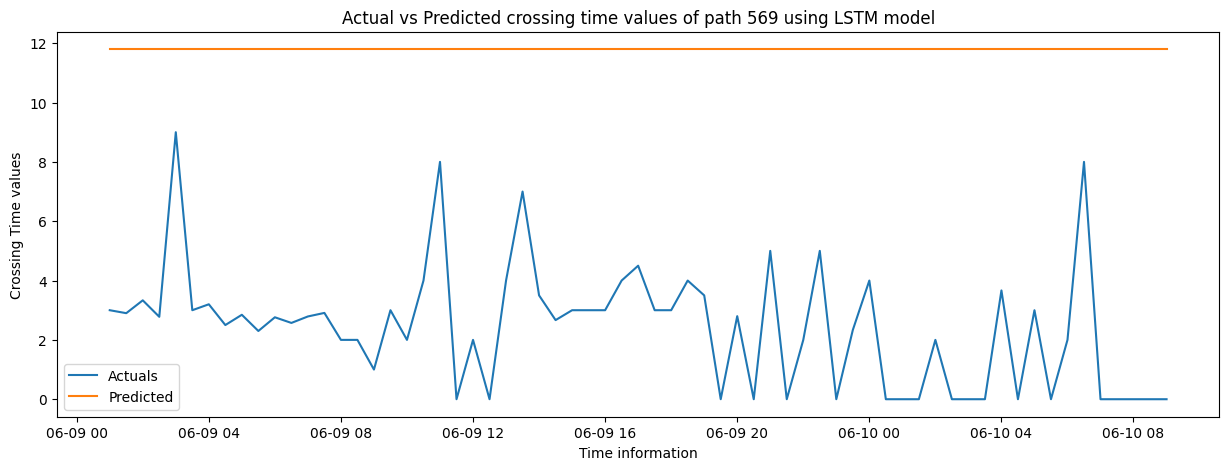

In [130]:
# Plot predictions from LSTM model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==569]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==569]['Predicted LSTM'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Crossing Time values')
plt.title('Actual vs Predicted crossing time values of path 569 using LSTM model')
plt.legend()
plt.plot()

Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [131]:
# Create dataframe with scores
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [132]:
# Print dataframe with all model scores
scores

,Model,RMSE Score,MAE Score
0,XGBoost,13.877889,5.411536
1,LSTM,20.509102,11.720781


In [134]:
# Save the model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_crossing_time.model')